# **Proyecto #8: Clustering y visualización de curvas de luz de estrellas periódicas**
## **EL4106 - Inteligencia Computacional - Primavera 2022**
### **Parte 2 : Reducción de dimensiones**
##### **Profesor:** Pablo Estevez
##### **Auxiliar:** Juan Uturria 
##### **Ayudante:** Rafael de la Sotta Vargas
##### **Estudiantes:** Macarena Ríos - Melanie Peña


## 1) Librerías a importar para la experiencia

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from google.colab import drive
from google.colab import files
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-tuner --upgrade

In [ ]:
pip install tensorflow

In [ ]:
#para el autoencoder
import math
import tensorflow as tf
import keras_tuner.tuners as kt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## 2) Unión de la data de características de todas las clases

In [2]:
#se cargan todas las dataframes de los features obtenidos y asignamos las clases correspondientes
CEP = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/CEP_features.csv")
CEP["classALeRCE"] = "CEP"
DSCT = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/DSCT_features.csv")
DSCT["classALeRCE"] = "DSCT"
E = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/E_features.csv")
E["classALeRCE"] = "E"
LPV = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/LPV_features.csv")
LPV["classALeRCE"] = "LPV"
POther = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/POther_features.csv")
POther["classALeRCE"] = "Periodic-Other"
RRL = pd.read_csv("/content/drive/MyDrive/Proyecto8/Features/RRL_features.csv")
RRL["classALeRCE"] = "RRL"

In [5]:
#continuamos uniendo toda la data en solo una data frame
first = pd.concat([CEP,DSCT],ignore_index=True)
second = pd.concat([first,E],ignore_index=True)
third = pd.concat([second,LPV],ignore_index=True)
fourth = pd.concat([third,POther],ignore_index=True)
final = pd.concat([fourth,RRL],ignore_index=True)


Para facilitar el proceso, se decide guardar este dataframe para utilizar a futuro.

In [4]:
#Código de ejemplo para poder descargar la data en un csv, descomentar si es necesario
#final.to_csv('features_totales.csv', index=False) 
#files.download('features_totales.csv')

##3) Situación inicial

In [14]:
#se carga la  data para no tener que correr la concatenación cada vez
final = pd.read_csv('/content/drive/MyDrive/Proyecto8/Features/features_totales.csv')
final

,oid,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,...,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,classALeRCE
0,ZTF17aabulac,1.155378,0.499402,0.432241,218.0,0.0,0.316374,0.179732,0.568099,324.0,...,-1.577956,0.524465,0.726911,1.0,0.001149,0.675791,-0.035507,8.204546e-01,0.000135,CEP
1,ZTF18aaxjixb,1.132515,0.365305,0.322561,98.0,0.0,0.789070,0.457251,0.579481,164.0,...,-1.462347,0.373529,0.628436,1.0,0.000683,0.510957,0.011341,7.331026e-01,-0.000085,CEP
2,ZTF18aauqjtk,3.794028,0.295547,0.077898,86.0,0.0,2.733041,0.428944,0.156947,165.0,...,-1.318882,0.407151,0.698594,1.0,0.000729,0.550771,-0.031368,9.271285e-01,-0.000126,CEP
3,ZTF18aaaaajq,0.847033,0.173251,0.204538,83.0,0.0,1.470625,0.755096,0.513452,72.0,...,-1.126781,0.376544,0.918371,1.0,0.000481,0.501414,-0.016520,3.724786e-13,0.000036,CEP
4,ZTF17aaadqhs,8.914537,2.292220,0.257133,9.0,0.0,2.679551,3.124052,1.165886,30.0,...,0.071383,0.483527,0.930662,1.0,0.000624,0.629238,-0.033390,8.618697e-02,0.000302,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,ZTF18abrymro,NaN,NaN,NaN,NaN,NaN,500.229095,1.112249,0.002223,6.0,...,-0.558214,0.276899,0.922015,1.0,0.000246,0.619373,0.253660,9.699323e-01,-0.007780,RRL
3613,ZTF19aacipqq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.545906,0.208093,0.933660,1.0,0.000129,0.360810,0.050974,1.304112e-03,-0.000099,RRL
3614,ZTF19abudhbr,NaN,NaN,NaN,NaN,NaN,32.730782,0.012715,0.000388,5.0,...,2.488790,0.213859,0.690182,1.0,0.000118,0.701657,0.627883,9.899342e-01,0.002072,RRL
3615,ZTF19aarsxkm,2.631819,0.067844,0.025778,4.0,0.0,95.264198,1.635817,0.017171,5.0,...,-1.676820,0.488585,0.957055,1.0,0.000845,15.000000,1.393247,7.731402e-01,0.000390,RRL


Revisando la data se puede verificar que hay una gran cantidad de características que no poseen valores númericos, es decir, son nulas para cierta cantidad de estrellas. Se procede a calcular cuantos valores nulos poseen cada una de las columnas/características.

In [6]:
#bloque para ver el nombre de las características que tenemos
keys = final.keys()
ft = keys.to_numpy()
ft

array(['oid', 'MHPS_ratio_r', 'MHPS_low_r', 'MHPS_high_r',
       'MHPS_non_zero_r', 'MHPS_PN_flag_r', 'MHPS_ratio_g', 'MHPS_low_g',
       'MHPS_high_g', 'MHPS_non_zero_g', 'MHPS_PN_flag_g',
       'Multiband_period', 'PPE', 'Period_band_r', 'delta_period_r',
       'Period_band_g', 'delta_period_g', 'GP_DRW_sigma_r',
       'GP_DRW_tau_r', 'GP_DRW_sigma_g', 'GP_DRW_tau_g', 'Psi_CS_r',
       'Psi_eta_r', 'Psi_CS_g', 'Psi_eta_g', 'Harmonics_mag_1_r',
       'Harmonics_mag_2_r', 'Harmonics_mag_3_r', 'Harmonics_mag_4_r',
       'Harmonics_mag_5_r', 'Harmonics_mag_6_r', 'Harmonics_mag_7_r',
       'Harmonics_phase_2_r', 'Harmonics_phase_3_r',
       'Harmonics_phase_4_r', 'Harmonics_phase_5_r',
       'Harmonics_phase_6_r', 'Harmonics_phase_7_r', 'Harmonics_mse_r',
       'Harmonics_mag_1_g', 'Harmonics_mag_2_g', 'Harmonics_mag_3_g',
       'Harmonics_mag_4_g', 'Harmonics_mag_5_g', 'Harmonics_mag_6_g',
       'Harmonics_mag_7_g', 'Harmonics_phase_2_g', 'Harmonics_phase_3_g',
       'Harm

In [7]:
#bloque para poder verificar cuantos valores nulos posee cada columna/característica
novalue = final.isna().sum()
aux = novalue.to_numpy()
aux

array([   0,  725,  725,  725,  725,  725,  331,  331,  331,  331,  331,
          1,    1,  462,  462,  167,  167,  312,  312,   61,   61,  354,
        354,   99,   99,  313,  313,  313,  313,  313,  313,  313,  313,
        313,  313,  313,  313,  313,  313,   62,   62,   62,   62,   62,
         62,   62,   62,   62,   62,   62,   62,   62,   62,  312,   61,
          1,    1,    1,    1,    1,    1,  462,  462,  462,  462,  462,
       2166,  462,  769,  462,  462,  462,  462,  462,  462,  462,  462,
        462,  462,  462,  462,  462,  462,  462,  462,  462,  462,  167,
        167,  167,  167,  167, 2000,  167,  426,  167,  167,  167,  167,
        167,  167,  167,  167,  167,  167,  167,  167,  167,  167,  167,
        167,  167,  167,    0])

In [8]:
#bloque para asignar a cada columna cuantos valores nulos posee en total
def assign(a,b):
  aux_list =[]
  for i in range(len(a)):
    x = [a[i],b[i]]
    aux_list.append(x)
  return aux_list

assign(ft,aux)

[['oid', 0],
 ['MHPS_ratio_r', 725],
 ['MHPS_low_r', 725],
 ['MHPS_high_r', 725],
 ['MHPS_non_zero_r', 725],
 ['MHPS_PN_flag_r', 725],
 ['MHPS_ratio_g', 331],
 ['MHPS_low_g', 331],
 ['MHPS_high_g', 331],
 ['MHPS_non_zero_g', 331],
 ['MHPS_PN_flag_g', 331],
 ['Multiband_period', 1],
 ['PPE', 1],
 ['Period_band_r', 462],
 ['delta_period_r', 462],
 ['Period_band_g', 167],
 ['delta_period_g', 167],
 ['GP_DRW_sigma_r', 312],
 ['GP_DRW_tau_r', 312],
 ['GP_DRW_sigma_g', 61],
 ['GP_DRW_tau_g', 61],
 ['Psi_CS_r', 354],
 ['Psi_eta_r', 354],
 ['Psi_CS_g', 99],
 ['Psi_eta_g', 99],
 ['Harmonics_mag_1_r', 313],
 ['Harmonics_mag_2_r', 313],
 ['Harmonics_mag_3_r', 313],
 ['Harmonics_mag_4_r', 313],
 ['Harmonics_mag_5_r', 313],
 ['Harmonics_mag_6_r', 313],
 ['Harmonics_mag_7_r', 313],
 ['Harmonics_phase_2_r', 313],
 ['Harmonics_phase_3_r', 313],
 ['Harmonics_phase_4_r', 313],
 ['Harmonics_phase_5_r', 313],
 ['Harmonics_phase_6_r', 313],
 ['Harmonics_phase_7_r', 313],
 ['Harmonics_mse_r', 313],
 ['Harmo

Es inmediato notar que las características 'Eta_e_r' y 'Eta_e_g' poseen valores elevados de valores nulos, es decir, una gran cantidad de el sample de las estrellas no poseen esta características en estas bandas.

##4) Dropeo de datos no numéricos

In [15]:
a = final.dropna()
a.reset_index(inplace=True,drop=True)
a

,oid,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,...,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g,classALeRCE
0,ZTF17aaadqhs,8.914537,2.292220,2.571328e-01,9.0,0.0,2.679551,3.124052,1.165886,30.0,...,0.071383,0.483527,0.930662,1.0,0.000624,0.629238,-0.033390,8.618697e-02,0.000302,CEP
1,ZTF18aaxmirs,15.984316,0.095876,5.998155e-03,16.0,0.0,2.278327,0.171551,0.075297,21.0,...,2.307524,0.128565,0.958503,1.0,0.000064,0.165612,-0.040225,4.571689e-01,0.000073,CEP
2,ZTF18abmouca,2.343719,0.714589,3.048952e-01,29.0,0.0,2.271718,1.240366,0.546004,36.0,...,-1.065999,0.416558,0.932456,1.0,0.000635,0.547031,-0.004455,4.221523e-01,0.000870,CEP
3,ZTF19aayumvw,662.891968,3.107009,4.687051e-03,4.0,0.0,26.523787,1.896718,0.071510,18.0,...,-0.314378,0.428974,0.969180,1.0,0.000659,0.641385,0.085179,9.589237e-01,-0.004286,CEP
4,ZTF18acpdmgr,9.904207,0.377262,3.809112e-02,25.0,0.0,6.836900,0.576028,0.084253,35.0,...,-1.232339,0.264136,0.950739,1.0,0.000237,0.475905,0.107153,4.230063e-13,0.000085,CEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,ZTF18abckcwg,38.811485,0.242926,6.259121e-03,1.0,0.0,68.446320,2.687710,0.039267,12.0,...,0.178896,0.429043,0.930876,1.0,0.000612,0.663432,0.021282,9.403493e-01,0.002176,RRL
704,ZTF19aayhtnq,7.807257,0.318194,4.075613e-02,7.0,0.0,8.252985,0.820302,0.099395,23.0,...,-0.984479,0.307360,0.831660,1.0,0.000383,0.452284,0.028643,8.117905e-01,-0.001870,RRL
705,ZTF17aabtxcs,310667.281250,0.174930,5.630790e-07,2.0,1.0,8.565926,2.274041,0.265475,13.0,...,-1.307930,0.460467,0.851940,1.0,0.000632,0.579313,-0.078193,4.800962e-13,0.000270,RRL
706,ZTF19aaysjcv,2.738855,0.606687,2.215112e-01,4.0,0.0,1.233003,0.486899,0.394889,7.0,...,1.589684,0.351267,0.906742,1.0,0.000474,0.763895,0.176183,2.717854e-06,0.000054,RRL


In [16]:
a.drop('oid', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**La data luego de dropear los valores no numéricos:**

{'CEP': 63, 'DSCT': 81, 'E': 96, 'LPV': 130, 'Periodic-Other': 133, 'RRL': 205}

Es inmediato notar un claro desbalance de la data, por lo que se procede a utilizar oversampling para poder aumentar la cantidad de estrellas para cada clase.

##5) Oversampling

In [17]:
#Separamos la data para realizar oversampling y luego normalización
features = ['MHPS_ratio_r', 'MHPS_low_r', 'MHPS_high_r',
       'MHPS_non_zero_r', 'MHPS_PN_flag_r', 'MHPS_ratio_g', 'MHPS_low_g',
       'MHPS_high_g', 'MHPS_non_zero_g', 'MHPS_PN_flag_g',
       'Multiband_period', 'PPE', 'Period_band_r', 'delta_period_r',
       'Period_band_g', 'delta_period_g', 'GP_DRW_sigma_r',
       'GP_DRW_tau_r', 'GP_DRW_sigma_g', 'GP_DRW_tau_g', 'Psi_CS_r',
       'Psi_eta_r', 'Psi_CS_g', 'Psi_eta_g', 'Harmonics_mag_1_r',
       'Harmonics_mag_2_r', 'Harmonics_mag_3_r', 'Harmonics_mag_4_r',
       'Harmonics_mag_5_r', 'Harmonics_mag_6_r', 'Harmonics_mag_7_r',
       'Harmonics_phase_2_r', 'Harmonics_phase_3_r',
       'Harmonics_phase_4_r', 'Harmonics_phase_5_r',
       'Harmonics_phase_6_r', 'Harmonics_phase_7_r', 'Harmonics_mse_r',
       'Harmonics_mag_1_g', 'Harmonics_mag_2_g', 'Harmonics_mag_3_g',
       'Harmonics_mag_4_g', 'Harmonics_mag_5_g', 'Harmonics_mag_6_g',
       'Harmonics_mag_7_g', 'Harmonics_phase_2_g', 'Harmonics_phase_3_g',
       'Harmonics_phase_4_g', 'Harmonics_phase_5_g',
       'Harmonics_phase_6_g', 'Harmonics_phase_7_g', 'Harmonics_mse_g',
       'iqr_r', 'iqr_g', 'Power_rate_1/4', 'Power_rate_1/3',
       'Power_rate_1/2', 'Power_rate_2', 'Power_rate_3', 'Power_rate_4',
       'Amplitude_r', 'AndersonDarling_r', 'Autocor_length_r',
       'Beyond1Std_r', 'Con_r', 'Eta_e_r', 'Gskew_r', 'MaxSlope_r',
       'Mean_r', 'Meanvariance_r', 'MedianAbsDev_r', 'MedianBRP_r',
       'PairSlopeTrend_r', 'PercentAmplitude_r', 'Q31_r', 'Rcs_r',
       'Skew_r', 'SmallKurtosis_r', 'Std_r', 'StetsonK_r', 'Pvar_r',
       'ExcessVar_r', 'SF_ML_amplitude_r', 'SF_ML_gamma_r', 'IAR_phi_r',
       'LinearTrend_r', 'Amplitude_g', 'AndersonDarling_g',
       'Autocor_length_g', 'Beyond1Std_g', 'Con_g', 'Eta_e_g', 'Gskew_g',
       'MaxSlope_g', 'Mean_g', 'Meanvariance_g', 'MedianAbsDev_g',
       'MedianBRP_g', 'PairSlopeTrend_g', 'PercentAmplitude_g', 'Q31_g',
       'Rcs_g', 'Skew_g', 'SmallKurtosis_g', 'Std_g', 'StetsonK_g',
       'Pvar_g', 'ExcessVar_g', 'SF_ML_amplitude_g', 'SF_ML_gamma_g',
       'IAR_phi_g', 'LinearTrend_g']

x = a.loc[:, features] #se define la data correspondiente las características
y = a.loc[:, ['classALeRCE']] #se define la data correspondiente a las clases, que corresponde a el target

### Data correspondiente a las características


In [ ]:
x

,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,...,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g
0,8.914537,2.292220,2.571328e-01,9.0,0.0,2.679551,3.124052,1.165886,30.0,0.0,...,-1.190934,0.071383,0.483527,0.930662,1.0,0.000624,0.629238,-0.033390,8.618697e-02,0.000302
1,15.984316,0.095876,5.998155e-03,16.0,0.0,2.278327,0.171551,0.075297,21.0,0.0,...,-0.914491,2.307524,0.128565,0.958503,1.0,0.000064,0.165612,-0.040225,4.571689e-01,0.000073
2,2.343719,0.714589,3.048952e-01,29.0,0.0,2.271718,1.240366,0.546004,36.0,0.0,...,-0.724818,-1.065999,0.416558,0.932456,1.0,0.000635,0.547031,-0.004455,4.221523e-01,0.000870
3,662.891968,3.107009,4.687051e-03,4.0,0.0,26.523787,1.896718,0.071510,18.0,0.0,...,-0.908307,-0.314378,0.428974,0.969180,1.0,0.000659,0.641385,0.085179,9.589237e-01,-0.004286
4,9.904207,0.377262,3.809112e-02,25.0,0.0,6.836900,0.576028,0.084253,35.0,0.0,...,-0.612255,-1.232339,0.264136,0.950739,1.0,0.000237,0.475905,0.107153,4.230063e-13,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,38.811485,0.242926,6.259121e-03,1.0,0.0,68.446320,2.687710,0.039267,12.0,0.0,...,-1.001056,0.178896,0.429043,0.930876,1.0,0.000612,0.663432,0.021282,9.403493e-01,0.002176
704,7.807257,0.318194,4.075613e-02,7.0,0.0,8.252985,0.820302,0.099395,23.0,0.0,...,0.580335,-0.984479,0.307360,0.831660,1.0,0.000383,0.452284,0.028643,8.117905e-01,-0.001870
705,310667.281250,0.174930,5.630790e-07,2.0,1.0,8.565926,2.274041,0.265475,13.0,0.0,...,0.329220,-1.307930,0.460467,0.851940,1.0,0.000632,0.579313,-0.078193,4.800962e-13,0.000270
706,2.738855,0.606687,2.215112e-01,4.0,0.0,1.233003,0.486899,0.394889,7.0,0.0,...,-1.086373,1.589684,0.351267,0.906742,1.0,0.000474,0.763895,0.176183,2.717854e-06,0.000054


### Data correspondiente a las clases

In [ ]:
y

,classALeRCE
0,CEP
1,CEP
2,CEP
3,CEP
4,CEP
...,...
703,RRL
704,RRL
705,RRL
706,RRL


In [18]:
#Usamos SMOTE para hacer oversampling hasta alcanzar a la clase mayoritaria RRL
smt = SMOTE()
x_sm, y_sm = smt.fit_resample(x,y)

In [19]:
x_sm

,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,...,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g
0,8.914537e+00,2.292220,2.571328e-01,9.000000,0.000000,2.679551,3.124052,1.165886,30.000000,0.000000,...,-1.190934,0.071383,0.483527,0.930662,1.000000,0.000624,0.629238,-0.033390,8.618697e-02,0.000302
1,1.598432e+01,0.095876,5.998155e-03,16.000000,0.000000,2.278327,0.171551,0.075297,21.000000,0.000000,...,-0.914491,2.307524,0.128565,0.958503,1.000000,0.000064,0.165612,-0.040225,4.571689e-01,0.000073
2,2.343719e+00,0.714589,3.048952e-01,29.000000,0.000000,2.271718,1.240366,0.546004,36.000000,0.000000,...,-0.724818,-1.065999,0.416558,0.932456,1.000000,0.000635,0.547031,-0.004455,4.221523e-01,0.000870
3,6.628920e+02,3.107009,4.687051e-03,4.000000,0.000000,26.523787,1.896718,0.071510,18.000000,0.000000,...,-0.908307,-0.314378,0.428974,0.969180,1.000000,0.000659,0.641385,0.085179,9.589237e-01,-0.004286
4,9.904207e+00,0.377262,3.809112e-02,25.000000,0.000000,6.836900,0.576028,0.084253,35.000000,0.000000,...,-0.612255,-1.232339,0.264136,0.950739,1.000000,0.000237,0.475905,0.107153,4.230063e-13,0.000085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2.279374e+08,6.732215,2.810297e-08,1.000000,1.000000,20282.363186,8.322468,0.000452,2.695965,0.869541,...,2.442970,12.093795,20.283204,0.673251,1.000000,-0.455179,1.021918,-0.131254,9.628767e-01,0.040283
1226,7.064797e+02,0.776991,8.091978e-02,22.036246,0.614688,1.625497,0.227285,0.163852,7.082499,0.000000,...,0.243946,0.770104,0.196093,0.861087,1.000000,0.000132,0.225580,0.027049,1.841498e-01,-0.000213
1227,1.397569e+00,0.147647,1.173354e-01,5.658331,0.000000,1.585390,0.062192,0.058136,6.289287,0.000000,...,0.330728,0.671930,0.139208,0.801133,1.000000,0.000070,0.207156,-0.011028,9.413058e-06,-0.000167
1228,4.970385e+00,0.340708,5.398785e-02,2.648151,0.000000,24.700286,0.135557,0.004689,5.160504,0.000000,...,0.355468,-1.328538,0.167182,0.953519,1.000000,0.000139,0.379129,0.272403,1.815519e-01,0.000408


In [20]:
y_sm

,classALeRCE
0,CEP
1,CEP
2,CEP
3,CEP
4,CEP
...,...
1225,Periodic-Other
1226,Periodic-Other
1227,Periodic-Other
1228,Periodic-Other


**Se añadió una columna de prueba para contar las clases:**

{'CEP': 205,
 'DSCT': 205,
 'E': 205,
 'LPV': 205,
 'Periodic-Other': 205,
 'RRL': 205}

 **ESTÁN BALANCEADAS**

In [ ]:
#Código auxiliar para poder contar que las clases esten balanceadas, descomentar en caso de ser necesario
#y_sm["a"]="b"
#y_sm.groupby(by="classALeRCE").count()["a"].to_dict()

##6) Normalización de features

In [22]:
#se normaliza la data
scaler = MinMaxScaler()
X_sm = scaler.fit_transform(x_sm)
X_sm

array([[7.28321741e-10, 2.12728202e-02, 1.14396643e-01, ...,
        2.15317747e-01, 8.61869756e-02, 6.58430585e-01],
       [1.27979001e-09, 8.92623556e-04, 2.66853873e-03, ...,
        2.12164026e-01, 4.57168890e-01, 6.57349512e-01],
       [2.15774176e-10, 6.63374679e-03, 1.35645812e-01, ...,
        2.28669969e-01, 4.22152297e-01, 6.61112071e-01],
       ...,
       [1.41971076e-10, 1.37301423e-03, 5.22017392e-02, ...,
        2.25636799e-01, 9.41305746e-06, 6.56214421e-01],
       [4.20663605e-10, 3.16445234e-03, 2.40188334e-02, ...,
        3.56426648e-01, 1.81551861e-01, 6.58933350e-01],
       [1.44454948e-09, 3.55092220e-04, 8.71109710e-04, ...,
        5.88262034e-02, 7.01076208e-01, 6.58025200e-01]])

In [23]:
#con oversampling
X_sm = pd.DataFrame(X_sm, columns=features)
X_sm

,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,...,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g
0,7.283217e-10,0.021273,1.143966e-01,0.018265,0.000000,1.130378e-14,0.009633,0.329828,0.076115,0.000000,...,0.140613,0.010985,0.012185,0.868638,1.000000,0.999179,0.072854,0.215318,8.618698e-02,0.658431
1,1.279790e-09,0.000893,2.668539e-03,0.034247,0.000000,1.038530e-14,0.000569,0.021301,0.052493,0.000000,...,0.156942,0.022933,0.002990,0.925316,1.000000,0.999154,0.042943,0.212164,4.571689e-01,0.657350
2,2.157742e-10,0.006634,1.356458e-01,0.063927,0.000000,1.037017e-14,0.003850,0.154464,0.091864,0.000000,...,0.168146,0.004907,0.010451,0.872289,1.000000,0.999180,0.067550,0.228670,4.221523e-01,0.661112
3,5.174092e-08,0.028833,2.085238e-03,0.006849,0.000000,6.588765e-14,0.005865,0.020230,0.044619,0.000000,...,0.157307,0.008923,0.010772,0.947053,1.000000,0.999181,0.073638,0.270032,9.589238e-01,0.636760
4,8.055196e-10,0.003504,1.694649e-02,0.054795,0.000000,2.082072e-14,0.001811,0.023835,0.089239,0.000000,...,0.174795,0.004019,0.006502,0.909510,1.000000,0.999162,0.062962,0.280172,8.838720e-14,0.657408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,1.777994e-02,0.062472,1.248369e-08,0.000000,1.000000,4.643525e-11,0.025591,0.000128,0.004451,0.869541,...,0.355268,0.075223,0.525100,0.344597,1.000000,0.978894,0.098188,0.170159,9.628767e-01,0.847274
1226,5.514093e-08,0.007213,3.600067e-02,0.048028,0.614688,8.890854e-15,0.000740,0.046354,0.015965,0.000000,...,0.225371,0.014718,0.004739,0.726995,1.000000,0.999158,0.046812,0.243208,1.841498e-01,0.655999
1227,1.419711e-10,0.001373,5.220174e-02,0.010635,0.000000,8.799041e-15,0.000233,0.016447,0.013883,0.000000,...,0.230498,0.014193,0.003266,0.604941,1.000000,0.999155,0.045623,0.225637,9.413057e-06,0.656214
1228,4.206636e-10,0.003164,2.401883e-02,0.003763,0.000000,6.171332e-14,0.000458,0.001327,0.010920,0.000000,...,0.231959,0.003505,0.003990,0.915171,1.000000,0.999158,0.056718,0.356427,1.815519e-01,0.658933


In [24]:
#sin oversampling
S_os = scaler.fit_transform(x)
S_os = pd.DataFrame(S_os, columns=features)
S_os

,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,MHPS_non_zero_r,MHPS_PN_flag_r,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,...,Skew_g,SmallKurtosis_g,Std_g,StetsonK_g,Pvar_g,ExcessVar_g,SF_ML_amplitude_g,SF_ML_gamma_g,IAR_phi_g,LinearTrend_g
0,7.283217e-10,0.021273,1.143966e-01,0.018265,0.0,1.130378e-14,0.009633,0.329828,0.076115,0.0,...,0.140613,0.010985,0.012185,0.868638,1.0,0.999179,0.072854,0.215318,8.618698e-02,0.658431
1,1.279790e-09,0.000893,2.668539e-03,0.034247,0.0,1.038530e-14,0.000569,0.021301,0.052493,0.0,...,0.156942,0.022933,0.002990,0.925316,1.0,0.999154,0.042943,0.212164,4.571689e-01,0.657350
2,2.157742e-10,0.006634,1.356458e-01,0.063927,0.0,1.037017e-14,0.003850,0.154464,0.091864,0.0,...,0.168146,0.004907,0.010451,0.872289,1.0,0.999180,0.067550,0.228670,4.221523e-01,0.661112
3,5.174092e-08,0.028833,2.085238e-03,0.006849,0.0,6.588765e-14,0.005865,0.020230,0.044619,0.0,...,0.157307,0.008923,0.010772,0.947053,1.0,0.999181,0.073638,0.270032,9.589238e-01,0.636760
4,8.055196e-10,0.003504,1.694649e-02,0.054795,0.0,2.082072e-14,0.001811,0.023835,0.089239,0.0,...,0.174795,0.004019,0.006502,0.909510,1.0,0.999162,0.062962,0.280172,8.838720e-14,0.657408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,3.060392e-09,0.002257,2.784641e-03,0.000000,0.0,1.618561e-13,0.008293,0.011109,0.028871,0.0,...,0.151829,0.011559,0.010774,0.869073,1.0,0.999179,0.075060,0.240547,9.403493e-01,0.667284
704,6.419498e-10,0.002956,1.813213e-02,0.013699,0.0,2.406240e-14,0.002560,0.028119,0.057743,0.0,...,0.245242,0.005343,0.007622,0.667088,1.0,0.999169,0.061438,0.243943,8.117905e-01,0.648172
705,2.423320e-05,0.001626,2.504909e-07,0.002283,1.0,2.477878e-14,0.007023,0.075103,0.031496,0.0,...,0.230409,0.003615,0.011588,0.708374,1.0,0.999180,0.069633,0.194644,1.454771e-13,0.658278
706,2.465962e-10,0.005633,9.854883e-02,0.006849,0.0,7.992361e-15,0.001537,0.111714,0.015748,0.0,...,0.146789,0.019097,0.008759,0.819940,1.0,0.999173,0.081542,0.312026,2.717854e-06,0.657261


##7) Verificación de resultados preliminares con PCA

In [25]:
#PCA
pca = PCA(n_components=2)
pca.fit(X_sm)
X_pca = pca.transform(X_sm)

In [26]:
X_pca.shape

(1230, 2)

In [27]:
pca.fit(S_os)
S_pca = pca.transform(S_os)

In [28]:
S_pca.shape

(708, 2)

In [29]:
S = y
S['eje0']=S_pca[:,0]
S['eje1']=S_pca[:,1]

In [30]:
P = y_sm
P['eje0']=X_pca[:,0]
P['eje1']=X_pca[:,1]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


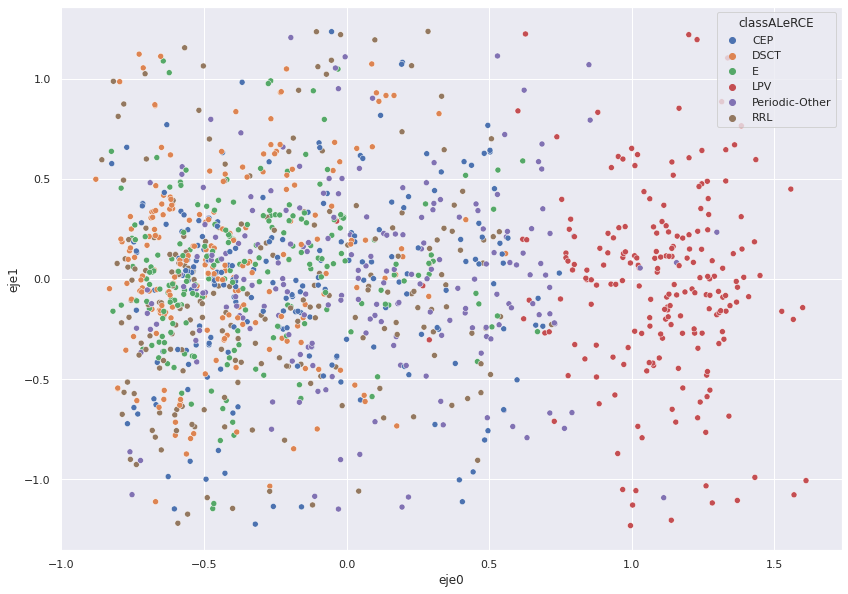

In [34]:
sns.scatterplot('eje0','eje1',data=P, hue='classALeRCE')
sns.set(rc={'figure.figsize':(14,10)})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


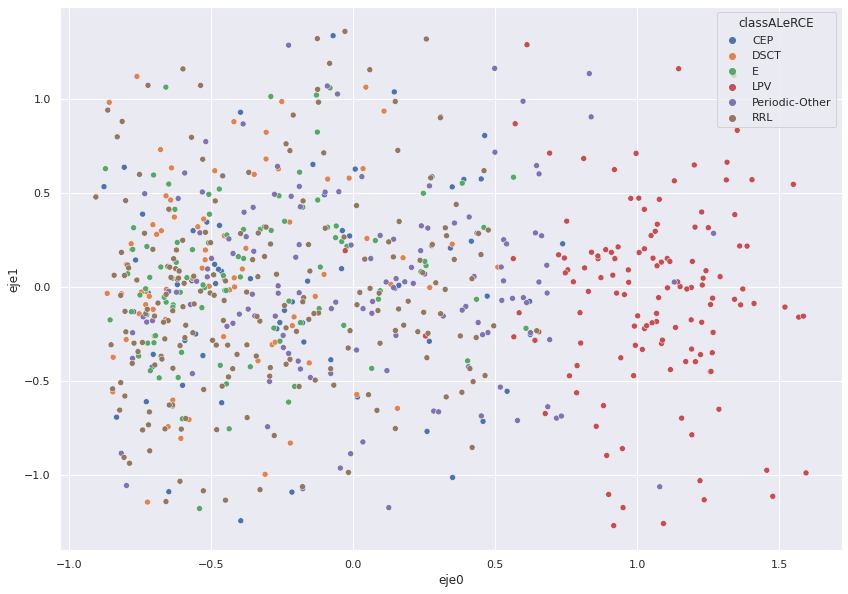

In [33]:
sns.scatterplot('eje0','eje1',data=S, hue='classALeRCE')
sns.set(rc={'figure.figsize':(14,10)})
plt.show()

##8) Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=1, train_size = .75)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(922, 112)
(922, 1)
(308, 112)
(308, 1)


## 9) Autoencoder (NO FUNCIONAL)


In [ ]:
class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(32, activation="relu"),
          Dense(16, activation="relu"),
          Dense(7, activation="relu")
        ]
    )

    self.decoder = Sequential(
        [
          Dense(16, activation="relu"),
          Dense(32, activation="relu"),
          Dense(output_units, activation="sigmoid")
        ]
    )

def call(self, inputs):

  encoded = self.encoder(inputs)
  decoded = self.decoder(encoded)
  return decoded
  
auto_encoder = AutoEncoders(len(X_train.columns))

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

history = auto_encoder.fit(
    x_train_scaled, 
    x_train_scaled, 
    epochs=15, 
    batch_size=32, 
    validation_data=(x_test_scaled, x_test_scaled)
)